## How mismodeling the cue can impact the probe activation estimate

The following set of simulations focuses on study designs where a cue is followed by a probe in each trial with fixation between the cue/probe and between trials.  It is reasonable to assume that we may not properly model the true cue duration, since we cannot know for certain whether the process elicited by the cue does not like stop exactly when fixation period between the cue and probe begins.  It could even be shorter than the cue regressor, only the oracle knows.  The question is whether this potential mismodeling of the cue can impact the activation estimate of the probe.  From previous simulations is seems that when the probe activation is truly 0, mismodeling the cue can bias the probe activation estimate.

Going into this the hypothesis is the following.  We know that with convolved regressors, the amplitude of the activation can be biased to account for duration differences.  For example, if the true duration is 2s and the true amplitude is 1, if a 1s duration regressor is used in the model the estimated activation magnitude will be 2 and the model will fit nearly identically to if the proper duration was used!  This ability of the amplitude to address duration misspecifications holds for up to around 2s.  What this means is if the true cue duration is 2s and the cue regressor's duration is 1s, that cue regressor can easily model almost all of the cue signal (leaving nothing to mess with the probe activation estimate).  On the other hand, if the true cue duration is 4s long, if the cue regressor's duration is only 1s, it cannot model all of the cue signal because the amplitude/duration relationship is nonlinear after 2s and the regressor will not be able to model the full width of the signal.  This means cue-based variability is left over and due to the hemodynamic delay, unless the cue and probe are separated by a lot of time, the probe regressor can pick up this variability as we will see.

Side note.  Based on what I just said, it may be tempting to think that spacing out the cue and probe as much as possible is the answer *but* this is unlikely to work well.  Why?  Because it is likely that whatever process that is elicited by the cue is still happening between the cue and probe stimuli.  In other words, it is likely that the fixation between the cue and probe contains some of that cue-driven activity (I'm just a statistician, but this seems reasonable to assume).  In this case there's no hope in modeling that activity that could blur into the probe activation estimate.  

Now to test my hypothesis!  First some functions to run things and then I do the following
* Simulation 1: Simulate data where the true cue duration = 4s, but the model for cue is only 1s.  There is no probe effect present and there's about a 1s fixation between the cue/probe and probe of this trial and cue of next trial.  No worries, it is enough to avoid high collinearity according to VIF, but of course the regressors will be correlated.
* Simulation 2: Repeat the above but look at a range of true cue durations between .5s-4s to see when the probe activation estimate becomes biased.
* Simulation 3: Extend the fixation between the cue and probe.  This slightly reduces the collinearity between regressors (which isn't bad to begin with), but does not alleviate the problem.
* Illustrations to show why the probe activation estimate is negatively biased.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from nilearn.glm.first_level import make_first_level_design_matrix


In [2]:
def sample_shifted_truncated_exponential(exp_lam, T, shift, nsamp):
    '''
    Samples nsamp values from a shifted and truncated exponential distribution
    Input:
      exp_lam: rate parameter for exponential (untruncated mean is 1/lambda)
      T: Truncation value (before shift)
      shift: shift value
      nsamp:  The number of samples desired
    Output:
      samples: samples from the distribution
      theoretical_mean:  The theoretical mean of the distribution (Likely smaller than 1/lambda,
        depending on how low truncation value is)
    '''
    theoretical_mean = shift + 1/exp_lam - T/(np.exp(exp_lam*T)-1)
    R = np.random.uniform(0, 1, nsamp) * (1-np.exp(-T*exp_lam))
    samples = -1*np.log(1-R) * 1/exp_lam + shift
    return samples, theoretical_mean

In [3]:
def make_timings(nper_cond, cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                             cue_probe_shift,  iti_exp_lam, iti_truncation, 
                             iti_shift):
    '''

    '''
    ntrials = nper_cond * 2
    cue_probe_fix, _ = sample_shifted_truncated_exponential(cue_probe_exp_lam, cue_probe_truncation, 
                                                    cue_probe_shift, ntrials)
    iti_vals, _ = sample_shifted_truncated_exponential(iti_exp_lam, iti_truncation, 
                                                    iti_shift, ntrials)
    # fragments = all sub-components of the run (go/stop/fixation/blank/break_message)
    # Each stimulus has 3 fragments and each break has 3 fragments
    trial_count = 0
    fragment_durations = []
    fragment_labels = []
    stim_type_block = np.random.permutation(np.concatenate((np.repeat(['cond1'], nper_cond),
                                                    np.repeat(['cond2'], nper_cond))))
    for cur_trial in range(ntrials):
        cur_stim_type = stim_type_block[cur_trial]
        fragment_durations.extend([iti_vals[trial_count], cue_dur, cue_probe_fix[trial_count], probe_dur])
        fragment_labels.extend(['iti_fix', f'cue_{cur_stim_type}', 'cue_probe_fix', f'probe_{cur_stim_type}'])
        trial_count = trial_count + 1
        
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('cond1|cond2')==True]
    return events_data

In [4]:
def sim_model_data(nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
           cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
           beta_probe1, beta_probe2, noise_sd, make_unconvolved=False
           ):
    '''
    Simulates data where the task involves a cue followed by a probe.  There are 
    2 condition types and the model includes a cue and probe regressor for each 
    condition type.  The true cue dur can differ from the modeled cue dur.  If 
    the cue is mismodeled, how can this impact our estimates of feedback?  
    When does this occur?
    Input
    npercond : Number of trials per condition (e.g. 20 = 20 trials for each 
               condition and 40 total trials)
    true_cue_dur:   The true cue duration
    model_cue_dur:  The modeled cue duration.  Note, it is up to the user to avoid 
                    durations that will run into the feedback.  
                    Also, the correct onset is used, so the model misspecification 
                    only reflects duration misspecification
    probe_dur:      Duration of the probe (same value used for true and modeled probe duration)
    cue_probe exp_lam/truncation/shift : Truncated exponential distribution 
                                         parameters for the fixation between cue and probe
    iti exp_lam/truncation/shift:        Truncated exponential distribution 
                                         parameters for the fixation between probe 
                                         of current trial and cue of next trial
    beta_cue1/cue2: True parameter estimates for cue
    beta_probe1/2: True parameter estimates for probe
    make_unconvolved: Whether or not you want the unconvolved regressors 
    Output
    design_mats:  Dictionary of design matrices.  The convolved true design, modeled design and
                  if requested, the unconvolved true design
    coeffs: Coefficient estimates from the model
    ps:  P-values for the coefficients from the model
    '''
    events_data = make_timings(nper_cond, true_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                             cue_probe_shift,  iti_exp_lam, iti_truncation, 
                             iti_shift)
    events_data_cue_dur_1s = events_data.copy()
    events_data_cue_dur_1s.loc[events_data_cue_dur_1s['trial_type'].str.contains('cue'), 'duration'] = model_cue_dur

    scan_length = np.floor(events_data['onset'].max() + 20)
    frame_times = np.arange(0, scan_length, 1)

    design_mats = {}

    true_des = make_first_level_design_matrix(
        frame_times,
        events_data,
        hrf_model='spm',
        drift_model=None)
    design_mats['true_des'] = true_des

    cue_too_short_des = make_first_level_design_matrix(
        frame_times,
        events_data_cue_dur_1s,
        hrf_model='spm',
        drift_model=None)
    design_mats['cue_wrong'] = cue_too_short_des

    if make_unconvolved == True:
        unconvolved_true_des = make_first_level_design_matrix(
                                frame_times,
                                events_data,
                                hrf_model=None,
                                drift_model=None)
        design_mats['unconvolved_true_des'] = unconvolved_true_des
        unconvolved_wrong_des = make_first_level_design_matrix(
                                frame_times,
                                events_data_cue_dur_1s,
                                hrf_model=None,
                                drift_model=None)
        design_mats['unconvolved_wrong_des'] = unconvolved_wrong_des
    
    bold = 10 + beta_cue1 * true_des['cue_cond1'] + beta_cue2 * true_des['cue_cond2'] + \
           beta_probe1 * true_des['probe_cond1']+ beta_probe2 * true_des['probe_cond2'] + \
           np.random.normal(0, noise_sd, int(scan_length))
    model = sm.OLS(bold, cue_too_short_des).fit()
    return design_mats, model.params, model.pvalues

In [5]:
def run_sim(nsim, nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
           cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
           beta_probe1, beta_probe2, noise_sd, make_unconvolved=False):
    
    reg_names = ['cue_cond1', 'cue_cond2', 'probe_cond1', 'probe_cond2']
    coeffs = {name: np.empty((nsim,)) for name in reg_names}
    ps = {name: np.empty((nsim,)) for name in reg_names}

    for sim in range(nsim):
        _, coeffs_loop, ps_loop = sim_model_data(nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                                   cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
                                   beta_probe1, beta_probe2, noise_sd, make_unconvolved
                                   )
        for reg_name in reg_names:
            coeffs[reg_name][sim] = coeffs_loop[reg_name]
            ps[reg_name][sim] = ps_loop[reg_name]
    return pd.DataFrame(coeffs), pd.DataFrame(ps)

        
    

In [6]:
def est_vif(desmat):
    '''
    General variance inflation factor estimation.  Calculates VIF for all 
    regressors in the design matrix
    input:
        desmat: design matrix.  Intercept not required.
    output:
      vif_data: Variance inflation factor for each regressor in the design matrix
                generally goal is VIF<5
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    desmat_with_intercept = desmat.copy()
    desmat_with_intercept['intercept'] = 1
    vif_data = {}
    vif_data['regressor'] = []
    vif_data['VIF'] = []
    for i, name in enumerate(desmat_with_intercept.columns):
        if desmat_with_intercept[name].std() != 0:
            vif_data['regressor'].append(name)
            vif_data['VIF'].append(variance_inflation_factor(desmat_with_intercept.values, i))
    vif_data = pd.DataFrame(vif_data)
    return vif_data

## Simulation #1: True cue duration is 4s, but modeled as 1s causing a negative bias in probe activation estimate.
The fake data assume two conditions (randomly ordered) where a cue is followed by a probe for each condition. Here the fixation between cue/probe and between trials is about 1s long.  The true cue duration is 4s, but is modeled assuming 1s.  The true activation magnitude is 1 for cue and 0 for probe so rejection rates reflect power for cue and Type I error for probe.

The following reviews the fixation distribution used, shows the unconvolved regressors, VIF/correlation of regressors, then some data sets are simulated and analyzed to look at the distribution of the coefficient estimates and rejection rates.  Note I'm not using many simulations here, but there are enough to see the patterns.

In [7]:
nper_cond = 30
true_cue_dur = 4
model_cue_dur = 1
probe_dur = 2
cue_probe_exp_lam = 2
cue_probe_truncation = 4.5
cue_probe_shift = .5
iti_exp_lam = 2
iti_truncation = 4.5
iti_shift = .5
beta_cue1 = 1
beta_cue2 = 1
beta_probe1 = 0
beta_probe2 = 0
make_unconvolved=True

noise_sd = 1

Theoretical mean value = 0.9994445873382422


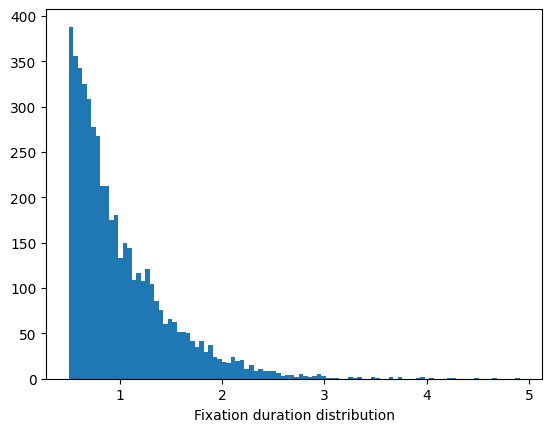

In [8]:
# FYI, fixation distribution (mean is about 1s)
nsamp = 5000
fix_durations, theoretical_mean = sample_shifted_truncated_exponential(cue_probe_exp_lam, cue_probe_truncation, cue_probe_shift, nsamp)

print(f'Theoretical mean value = {theoretical_mean}')

plt.hist(fix_durations, 100)
plt.xlabel('Fixation duration distribution')
plt.show()

In [9]:
# Look at unconvolved regressors
desmats, coeffs_loop, ps_loop = sim_model_data(nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                            cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
                            beta_probe1, beta_probe2, noise_sd, make_unconvolved=True
                            )

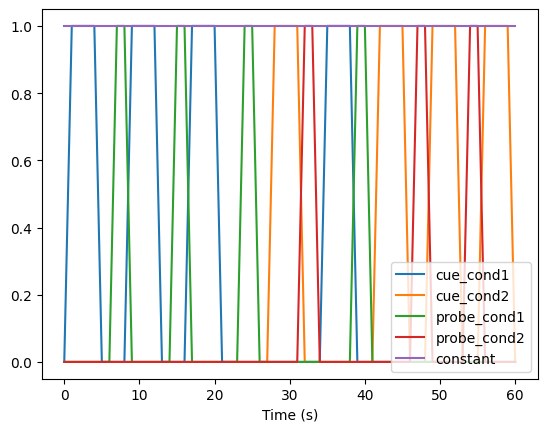

In [10]:
desmats['unconvolved_true_des'].loc[:60].plot(kind='line')
plt.xlabel('Time (s)')
plt.legend(loc='lower right')
plt.show()

In [11]:
# VIF
print(est_vif(desmats['cue_wrong']))
print(desmats['cue_wrong'].corr())

     regressor       VIF
0    cue_cond1  2.336082
1    cue_cond2  2.305388
2  probe_cond1  2.495580
3  probe_cond2  2.553785
             cue_cond1  cue_cond2  probe_cond1  probe_cond2  constant
cue_cond1     1.000000  -0.750817     0.138034    -0.211885       NaN
cue_cond2    -0.750817   1.000000    -0.150156     0.183463       NaN
probe_cond1   0.138034  -0.150156     1.000000    -0.772567       NaN
probe_cond2  -0.211885   0.183463    -0.772567     1.000000       NaN
constant           NaN        NaN          NaN          NaN       NaN


In [12]:
true_cue_dur = 4
model_cue_dur = 1
nsim = 1000

coeffs, ps = run_sim(nsim, nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
           cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
           beta_probe1, beta_probe2, noise_sd, make_unconvolved=False)



In [13]:
print('Rejection rates (probe should be 0.05)')
np.mean(ps <= 0.05, axis=0)


Rejection rates (probe should be 0.05)


cue_cond1      0.460
cue_cond2      0.487
probe_cond1    0.144
probe_cond2    0.157
dtype: float64

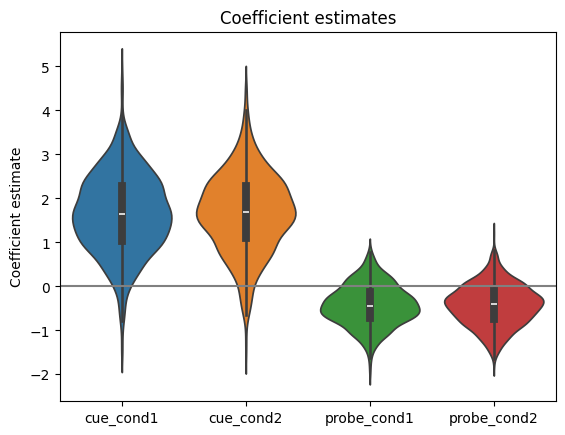

In [14]:
ax = sns.violinplot(data=coeffs)
ax.axhline(y=0, color='gray')
ax.set_title('Coefficient estimates')
ax.set_ylabel('Coefficient estimate')
plt.show()

## Simulation #2, study rejection rates for a range of cue durations (.5-4s) when modeled as a 1s duration.

Here I try to nail down *when* the cue mismodeling is bad enough to impact the probe estimate.  My hypothesis was this would happen when the true duration exceeded 2s, but it will be seen that it happens a bit later, likely due to collinearity (mild, but still present)

In [15]:
model_cue_dur = 1
true_cue_durs = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
n_durs = len(true_cue_durs)
nsim = 1000

reg_names = ['cue_cond1', 'cue_cond2', 'probe_cond1', 'probe_cond2']
coeff_mean = {name: np.empty((n_durs,)) for name in reg_names}
rej_rate = {name: np.empty((n_durs,)) for name in reg_names}


for ind, true_cue_dur in enumerate(true_cue_durs):
    coeffs, ps = run_sim(nsim, nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
            cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
            beta_probe1, beta_probe2, noise_sd, make_unconvolved=False)
    for reg_name in reg_names:
        coeff_mean[reg_name][ind] = np.mean(coeffs[reg_name])
        rej_rate[reg_name][ind] = np.mean(ps[reg_name] <= 0.05)
    

### Important considerations when viewing the following figure

The following shows how power (in the case of the cue regressors) and type I error (in the case of the probe regressors) changes as the true cue duration goes from .5s to 4s.  In all models the modeled cue duration is 1s.  It may seem weird the the power for cue is increasing, but this is simply because the true duration of the cue is increasing and so the magnitude of the cue BOLD activation estimate is a combination of BOLD amplitude and duration, whenever the true duration is not 1s long.  Interestingly we can see that eventually the ability of the 1s long cue duration regressor to fit the data fails because the linear relationship between duration and amplitude breaks down and the 1s duration regressor cannot adapt.  I hypothesized that this would happen around 2s, since that's where the linearity assumption breaks down, but it doesn't seem to show up here until 3.5-4s.  Once the cue regressor fails to fit the data well, the probe regressor picks up what the cue regressor fails to capture and the probe estimates have an elevated error rate.

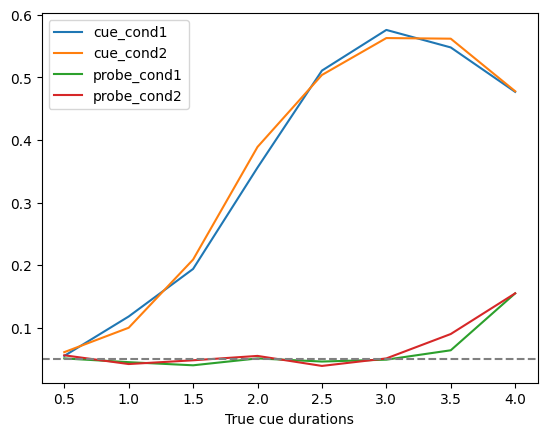

In [16]:
rej_rate_df = pd.DataFrame(rej_rate)
rej_rate_df['True cue durations'] = true_cue_durs

ax = rej_rate_df.plot(x='True cue durations', y=reg_names, kind='line')
ax.axhline(y=0.05, color='gray', ls='--')
plt.show()

## Simulation #3, lengthen fixation periods, true cue duration ranges between .5-4s and is modeled as 1s

What if I lengthen the fixation between the cue and probe?  I don't change the fixation between the trials.



Theoretical mean value = 2.913923435840002


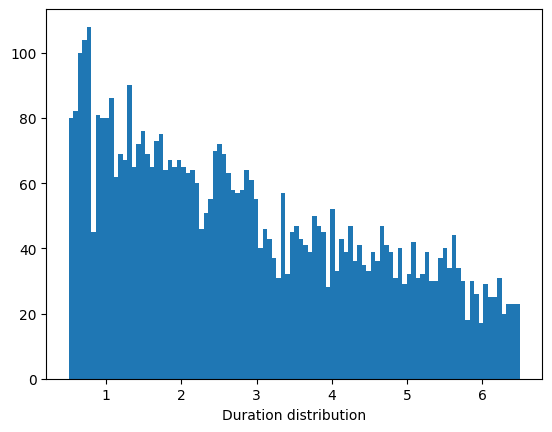

In [17]:
# Closer to 3s (previous was 1s) between cue and probe.  ITI is the same (about 1s)
cue_probe_exp_lam = .2
cue_probe_truncation = 6
cue_probe_shift = .5

nsamp = 5000
fix_durations, theoretical_mean = sample_shifted_truncated_exponential(cue_probe_exp_lam, cue_probe_truncation, cue_probe_shift, nsamp)

print(f'Theoretical mean value = {theoretical_mean}')

plt.hist(fix_durations, 100)
plt.xlabel('Duration distribution')
plt.show()

In [18]:
# Quick look at the VIFs
true_cue_dur = 4
cue_dur = 1
cue_probe_exp_lam = .2
cue_probe_truncation = 6
cue_probe_shift = .5

desmats, coeffs_loop, ps_loop = sim_model_data(nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                            cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
                            beta_probe1, beta_probe2, noise_sd, make_unconvolved=True
                            )

print(est_vif(desmats['cue_wrong']))
print(desmats['cue_wrong'].corr())

     regressor       VIF
0    cue_cond1  1.495364
1    cue_cond2  1.495825
2  probe_cond1  1.535610
3  probe_cond2  1.543153
             cue_cond1  cue_cond2  probe_cond1  probe_cond2  constant
cue_cond1     1.000000  -0.564859     0.076272    -0.006104       NaN
cue_cond2    -0.564859   1.000000    -0.034967     0.088948       NaN
probe_cond1   0.076272  -0.034967     1.000000    -0.581843       NaN
probe_cond2  -0.006104   0.088948    -0.581843     1.000000       NaN
constant           NaN        NaN          NaN          NaN       NaN


In [19]:
model_cue_dur = 1
true_cue_durs = [.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
n_durs = len(true_cue_durs)
nsim = 500

reg_names = ['cue_cond1', 'cue_cond2', 'probe_cond1', 'probe_cond2']
coeff_mean = {name: np.empty((n_durs,)) for name in reg_names}
rej_rate = {name: np.empty((n_durs,)) for name in reg_names}


for ind, true_cue_dur in enumerate(true_cue_durs):
    coeffs, ps = run_sim(nsim, nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
            cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
            beta_probe1, beta_probe2, noise_sd, make_unconvolved=False)
    for reg_name in reg_names:
        coeff_mean[reg_name][ind] = np.mean(coeffs[reg_name])
        rej_rate[reg_name][ind] = np.mean(ps[reg_name] <= 0.05)

### Interesting differences compared to last simulation

Here we see the error rate increases earlier for the probe and the power doesn't start to decrease for cue, even though we only changed the fixation between the cue and probe.  This must be driven by the reduced collinearity between the cue and probe regressors.  I'm not currently sure why the power doesn't decrease for cue as it did with the shorter fixation, but I'd assume it is related to collinearity?  I am still thinking this through.

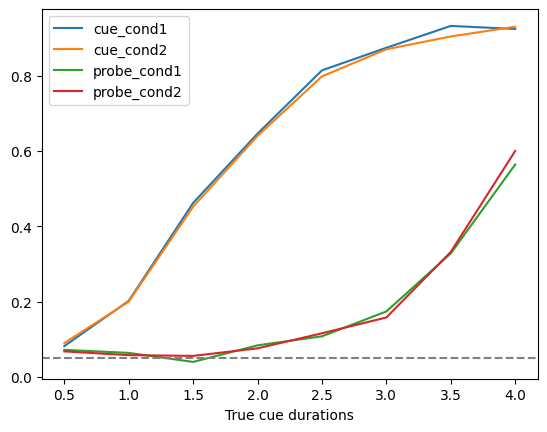

In [20]:
rej_rate_df = pd.DataFrame(rej_rate)
rej_rate_df['True cue durations'] = true_cue_durs

ax = rej_rate_df.plot(x='True cue durations', y=reg_names, kind='line')
ax.axhline(y=0.05, color='gray', ls='--')
plt.show()

## Why does mismodeling the cue end up negatively biasing the probe activation estimate?

In the following I apply a sequence of linear regressions that is equivalent to the multiple linear regression to illustrate how the cue regressor adjustment is impacting the parameter estimate of the probe activation estimate.  For clarity I omit noise and collapse the two cue and two probe regressors into single cue/probe regressors.

* Step 1: model cue the cue effect out of the data *and* out of the probe regressor.  
* Step 2: model the cue adjusted signal with the cue adjusted probe regressor.  Other than a DF difference (the final model in the sequence of models doesn't account for the DF that were already spent), the model results are equivalent. It is sufficient to observe the impact on the coefficient since there is no noise added here.

In the illustration below I focus on unconvolved regressors, because it is easier to see what is happening.  A convolved regressor example follows.  When the true duration of the cue is 4s long, the cue regressor, using a duration of 1s, only picks up the first 1s of cue activation, leaving 3s unmodeled.  In the cue adjusted signal you can see the small bit the regressor has modeled out (the boxcar is shorter).  In the cue adjusted probe regressor you can see a little blip where cue was removed.  If cue had been modeled properly, the signal residual would be all 0s, but instead it has 3/4 of the cue signal remaining and since the intercept was already modeled out the cue adjusted signal is centered about 0 with a strong negative component when the cue adjusted probe regressor is positive, which is why the probe regressor's parameter is negatively biased.

Of course with convolved regressors, the amplitude of the cue regressor coefficient can, to some degree, account for misspecified durations, but this is limited as the true duration extends beyond 2s.





In [21]:
true_cue_dur = 4
cue_dur = 1
cue_probe_exp_lam = 2
cue_probe_truncation = 4.5
cue_probe_shift = .5

desmats_true_dur4, coeffs_loop, ps_loop = sim_model_data(nper_cond, true_cue_dur, model_cue_dur, probe_dur, cue_probe_exp_lam, cue_probe_truncation, 
                            cue_probe_shift,  iti_exp_lam, iti_truncation, iti_shift, beta_cue1, beta_cue2, 
                            beta_probe1, beta_probe2, noise_sd, make_unconvolved=True)


In [22]:
true_signal = 10 + 10 * (desmats_true_dur4['unconvolved_true_des']['cue_cond1'] + desmats_true_dur4['unconvolved_true_des']['cue_cond2'])

cue_reg = desmats_true_dur4['unconvolved_wrong_des']['cue_cond1'] + desmats_true_dur4['unconvolved_wrong_des']['cue_cond2']
probe_reg = desmats_true_dur4['unconvolved_wrong_des']['probe_cond1'] + desmats_true_dur4['unconvolved_wrong_des']['probe_cond2']


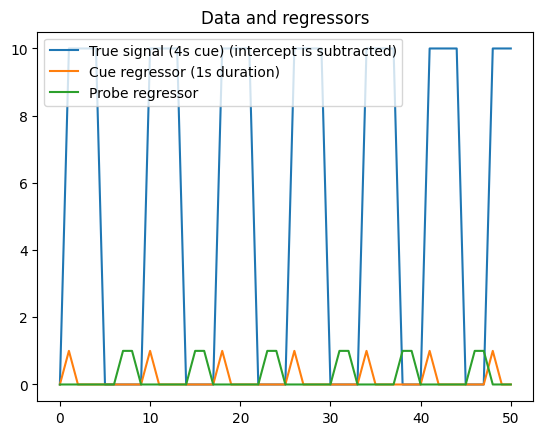

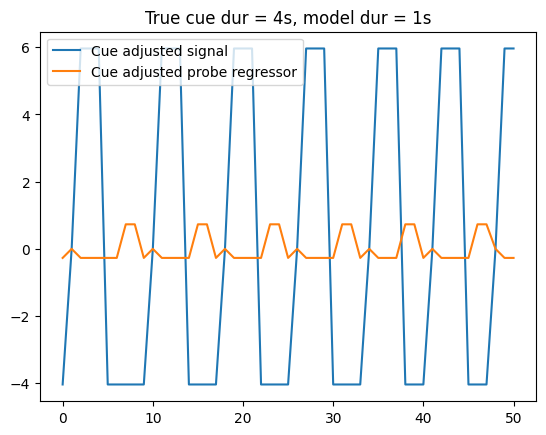

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
No. Observations:                 506   F-statistic:                     142.1
Covariance Type:            nonrobust   Prob (F-statistic):           1.19e-49
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5215      0.222     70.004      0.000      15.086      15.957
cue            4.4785      0.562      7.964      0.000       3.374       5.583
probe         -5.5215      0.427    -12.917      0.000      -6.361      -4.682

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
Dep. Variable:                 

In [23]:
plt.plot(true_signal.loc[:50] - 10, label='True signal (4s cue) (intercept is subtracted)')
plt.plot(cue_reg.loc[:50], label='Cue regressor (1s duration)')
plt.plot(probe_reg.loc[:50], label='Probe regressor')
plt.title('Data and regressors')
plt.legend(loc='upper left')
plt.show()

mod_cue_adj_signal = sm.OLS(true_signal, sm.add_constant(cue_reg)).fit()
signal_resid = mod_cue_adj_signal.resid 
mod_cue_adj_probe = sm.OLS(probe_reg, sm.add_constant(cue_reg)).fit()
probe_resid = mod_cue_adj_probe.resid

plt.plot(signal_resid.loc[:50], label='Cue adjusted signal')
plt.plot(probe_resid.loc[:50], label='Cue adjusted probe regressor')
plt.title('True cue dur = 4s, model dur = 1s')
plt.legend(loc='upper left')
plt.show()


desmat = sm.add_constant(pd.DataFrame({'cue': cue_reg, 'probe': probe_reg}))
mod = sm.OLS(true_signal, desmat).fit()
print(mod.summary(slim=True))

mod2 = sm.OLS(signal_resid, sm.add_constant(probe_resid)).fit()
print(mod2.summary(slim=True))

The same illustration, but using the convolved regressors

In [24]:
# Convolution is linear, so the sum of the regressors is equivalent to making a single cue regressor
true_signal = 10 + 10 * (desmats['true_des']['cue_cond1'] + desmats['true_des']['cue_cond2'])

cue_reg = desmats['cue_wrong']['cue_cond1'] + desmats['cue_wrong']['cue_cond2']
probe_reg = desmats['cue_wrong']['probe_cond1'] + desmats['cue_wrong']['probe_cond2']

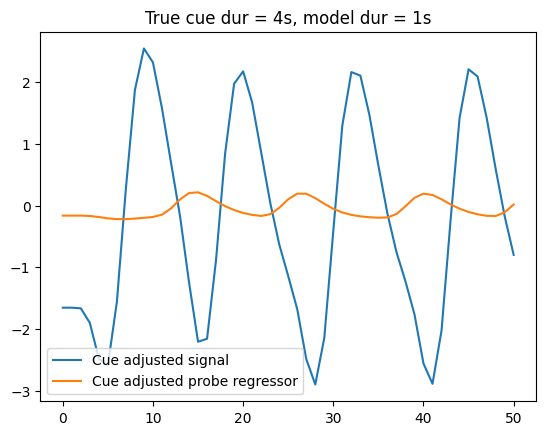

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.699
No. Observations:                 637   F-statistic:                     739.9
Covariance Type:            nonrobust   Prob (F-statistic):          1.65e-166
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9942      0.102    126.975      0.000      12.793      13.195
cue           24.7599      0.720     34.381      0.000      23.346      26.174
probe         -8.2640      0.374    -22.076      0.000      -8.999      -7.529

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                   OLS Regression Results                  
Dep. Variable:                      y   F-statisti

In [25]:
signal_resid = sm.OLS(true_signal, sm.add_constant(cue_reg)).fit().resid
probe_resid = sm.OLS(probe_reg, sm.add_constant(cue_reg)).fit().resid

plt.plot(signal_resid.loc[:50], label='Cue adjusted signal')
plt.plot(probe_resid.loc[:50], label='Cue adjusted probe regressor')
plt.title('True cue dur = 4s, model dur = 1s')
plt.legend()
plt.show()

desmat = sm.add_constant(pd.DataFrame({'cue': cue_reg, 'probe': probe_reg}))
mod = sm.OLS(true_signal, desmat).fit()
print(mod.summary(slim=True))

mod2 = sm.OLS(signal_resid, probe_resid).fit()
print(mod2.summary(slim=True))